In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix

## Part 1 - Exploratory data analysis

In [2]:
df_login = pd.read_json('logins.json', convert_dates=True)
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# check dtype
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# it can be performed with time series analysis
df_login.set_index('login_time', inplace=True)
df_login.sort_index(inplace=True)
df_login.head(10)

""
login_time
1970-01-01 20:12:16
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:36
1970-01-01 20:16:37
1970-01-01 20:21:41
1970-01-01 20:26:05
1970-01-01 20:26:21
1970-01-01 20:31:03


In [5]:
# verify count col and check dtype
df_login['count'] = 1
df_login.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:12:16 to 1970-04-13 18:57:38
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   93142 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [6]:
# resample data into 15 min frame
df_login = df_login.resample('15min').sum()
df_login.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
# input new columns for analysis
df_login['month'] = [m for m in df_login.index.month]
df_login['day'] = [d for d in df_login.index.day]
df_login['weekday'] = [d for d in df_login.index.dayofweek]
df_login['weekday_name'] = [d for d in df_login.index.day_name()]
df_login['date'] = [d for d in df_login.index.date]
df_login['time'] = [d.time() for d in df_login.index]
df_login.sample(5)

,count,month,day,weekday,weekday_name,date,time
login_time,,,,,,,
1970-02-16 07:00:00,1,2,16,0,Monday,1970-02-16,07:00:00
1970-01-29 15:15:00,10,1,29,3,Thursday,1970-01-29,15:15:00
1970-03-26 23:15:00,18,3,26,3,Thursday,1970-03-26,23:15:00
1970-03-05 00:30:00,17,3,5,3,Thursday,1970-03-05,00:30:00
1970-01-17 09:30:00,1,1,17,5,Saturday,1970-01-17,09:30:00


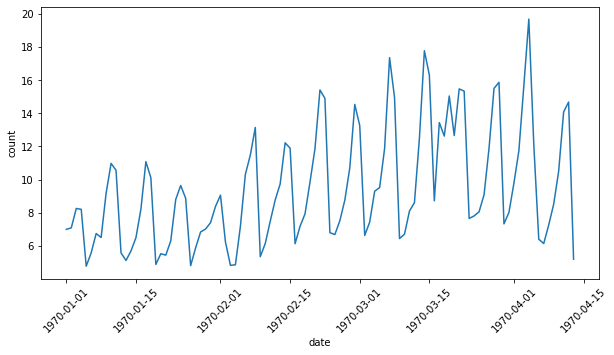

In [8]:
plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='count', data=df_login, ci=None)
plt.xticks(rotation=45);

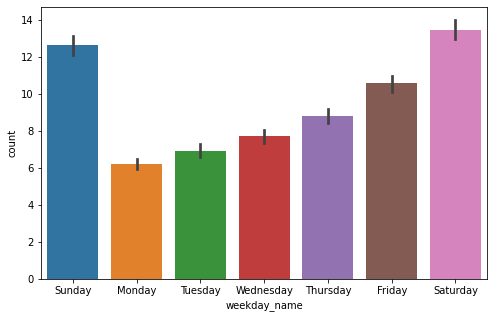

In [9]:
plt.figure(figsize=(8,5))
cat_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.barplot(x='weekday_name', y='count', data=df_login, order=cat_order);

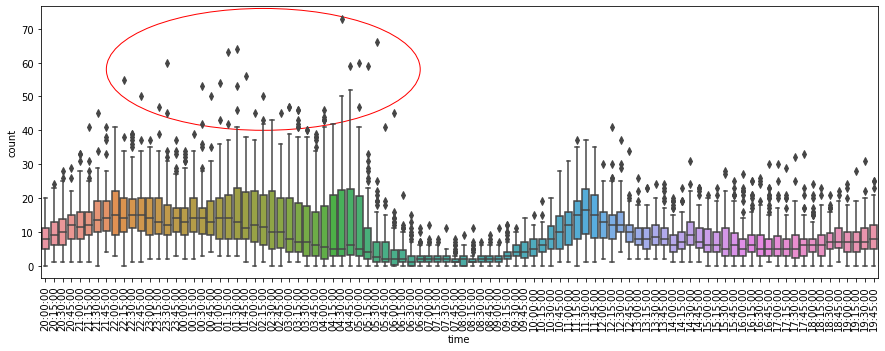

In [10]:
plt.figure(figsize=(15,5))
sns.boxplot(x='time', y='count', data=df_login)
plt.xticks(rotation=90)
circle1 = plt.Circle((25, 58), 18, color='r', fill=False)
plt.gca().add_patch(circle1);

The time between 05:30 and 10:30 has the least trips. The quiet morning hours may be due to people commuting to work to avoid heavy traffic. But the surprising fact is the wide variation between 23:00 and 05:30. Let's further explore that area.

<Figure size 1080x360 with 0 Axes>

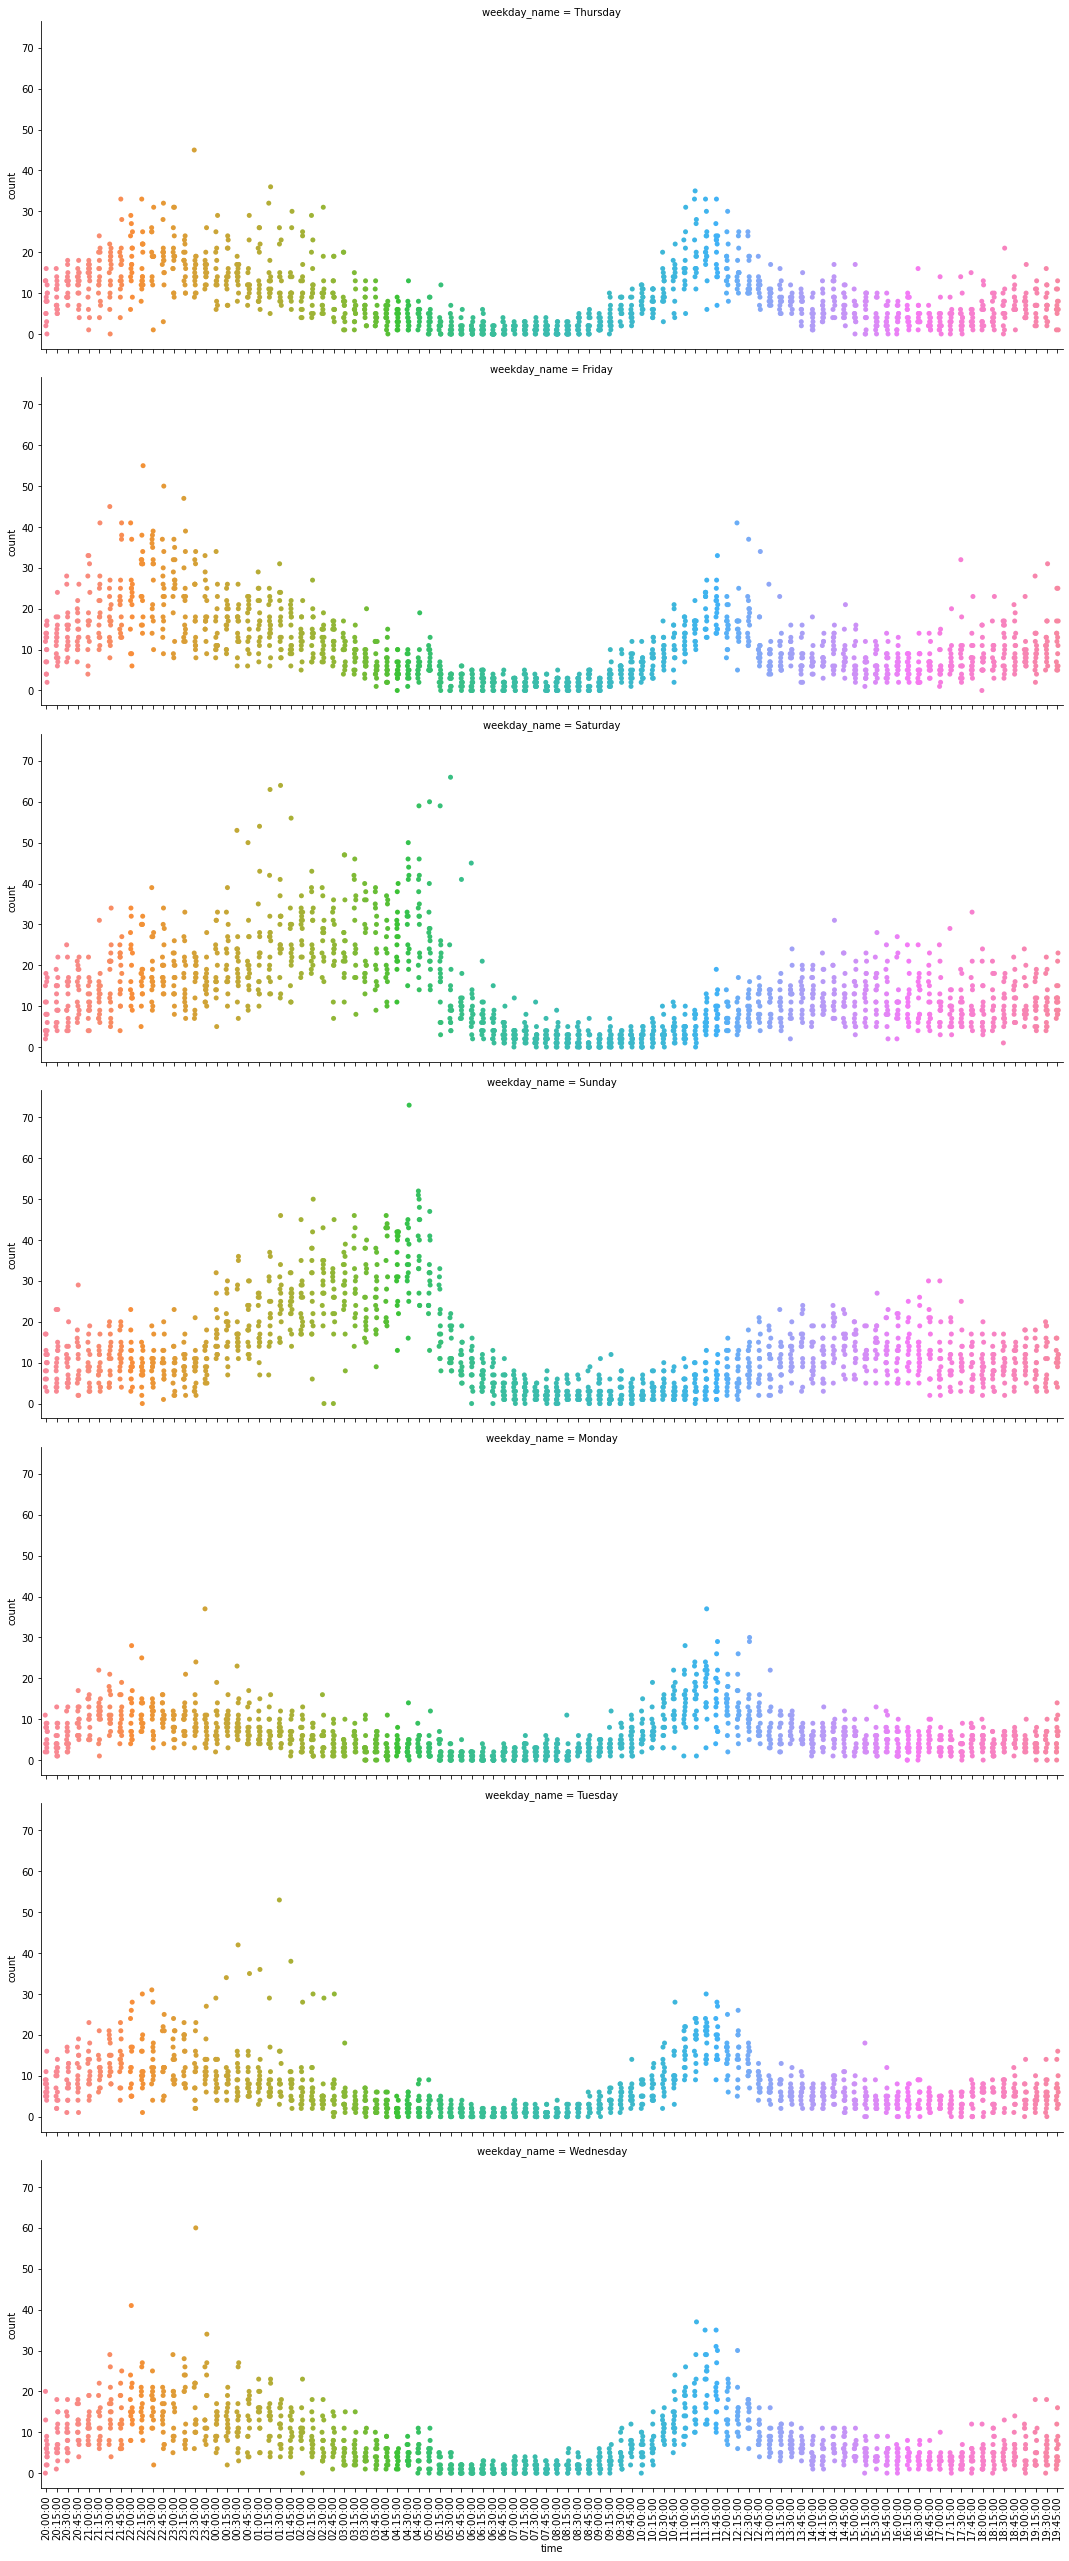

In [11]:
plt.figure(figsize=(15,5))
sns.catplot(x='time', y='count', row='weekday_name', data=df_login, height=5, aspect=15/5)
plt.xticks(rotation=90);

The plots above tell us 3 important observations:

1. Wide range between 23:00 and 05:30 is mainly on weekend trips. It could be due to people requesting a ride home after partying or some other reasons. 

2. Peak hours show between 10:30 to 13:00 on weekdays. It may be due to workers meeting their clients during this time.

3. Friday between 21:30 and 22:30 has a higher variance than any other days, most likely due to people working late or going for drinks on Fridays.

I believe our revenue will increase by capturing the high demand in these hours.

## Part 2 - Experiment and metrics design

Problem: driver partners tend to be exlusive to each city due to toll bridge costs

Solution: Toll costs reimbursed to drivers to encourage them servicing in both cities

Null hypothesis: amount or percentage of drivers does not change much, i.e., drivers remain only servicing in one of the cities after the proposed change

Alternative hypothesis: high amount or percentage of drivers now service in both cities after the proposed change

The amount or percentage of drivers is an important metric because this is what we want to find out if our reimbursement plan is an effective incentive or not.

Practical experiment:

a. Experiment:
- Include locations of pick-up and drop-off cities
- Group by drivers (supposed this column exists in another file), pick-up city, and drop-off city
- Count the unique values to see if the driver works in 1 city or 2 cities.

b. Statistical tests:

This is a problem of using categorical input to predict quantitative output from the same population as a pre and post setting. Hence, we will use the paired t-test for statistical testing.

c. Interpretations:
- If p-value < the critical value at 95% confidence interval, reject null hypothesis and conclude that our reimbursement plan is effective.
- If p-value > the critical value at 95% confidence interval, it means that our reimbursement interval may not work well, and we may promote other incentives to encourage driver partners servicing in both cities.
- One of the caveats is the amount of time we let the plan run before using the results in the statistical test, as drivers may take time to adapt to change.